# CNN Training with custom dataset

In [14]:
import torch 
import os 
from PIL import Image 
from torchvision import transforms # torch library for vision
from torch.utils.data import Dataset, DataLoader

In [15]:
# Dataset: https://drive.google.com/file/d/1G9H2W0R6JLYYBXyHNM_kAcBufUJr4Qsy/view
# !unzip './Classification_dataset_v3.zip'

In [16]:
image_dir = './Classification_dataset_v3/images/train'
for label, class_dir in enumerate(os.listdir(image_dir)):
    # iterate over the subdirectory corresponding to the classes 
    print(label, class_dir)

0 person
1 Dog
2 Cat


In [17]:
# Create image dataset dataloader 
# (batches and shuffle handler)
class ImageDataset(Dataset):
    # directory of the dataset 
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_paths = []
        self.labels = []      # create labels for images (structured label format)
        self.class_names = {} # Save names to retrieve the class names properly 

        self.transform = transform

        for label, class_dir in enumerate(os.listdir(image_dir)):
            # iterate over the subdirectory corresponding to the classes 
            self.class_names[label] = class_dir

            class_path = os.path.join(image_dir, class_dir)
            for image_name in os.listdir(class_path):
                self.image_paths.append(os.path.join(class_path, image_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        # the model expect an array, not the path! 
        image = Image.open(image_path).convert("RGB") # mention RGB convertion for safety
        # We use PIL image since transform expect aPIL image (or np array)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
            # resize and convert to tensor
            
        # return image and label when getitem is called intrnally 
        return image, label        

In [18]:
# The dataloader properly load the dataset..
# Images will be of different sizes and resolutions.. 
# Standardization needs to be done while making the batches for training *you use transforms) 

# different kind of transormation from transforms
# e.g.
transform = transforms.Compose([
    transforms.Resize((128, 128)), # lower resolution for fatser speed 
    transforms.ToTensor(), # instead of pillow image, pytorch model expect tensors 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalize in the range -1, 1
])

# Normalizing, if I have x = 255 -> (x - mean)/std as internal normalization between -1 and 1
# Normalizing pixels you can get better speed and accuracy (performs better)

# Mean and Std should be find appropriately from experiment, such as 
# mean = [0.485, 0.456, 0.406] in VGG and Image net and ResNet
# std = [0.229, 0.224, 0.225]

# With the transform it can be used on the image whenever the dataloader is called at initialization

In [19]:
# Create your own data loader 
# Two set of data for training and test for train and evaluation of performances
train_image_dir = './Classification_dataset_v3/images/train'
test_image_dir = './Classification_dataset_v3/images/test'

train_image_dataset = ImageDataset(train_image_dir, transform)
test_image_dataset = ImageDataset(test_image_dir, transform)

In [20]:
# Wrap dataset with data loader
train_image_loader = DataLoader(dataset=train_image_dataset, batch_size=32, shuffle=True)
test_image_loader = DataLoader(dataset=test_image_dataset, batch_size=32, shuffle=True)

# Load the dataset in batches and shuffling the dataset order 

In [21]:
# Check if it is working well 
for images, labels in train_image_loader:
    print(images.shape, labels.shape)
    break

torch.Size([32, 3, 128, 128]) torch.Size([32])


In [22]:
# Loading and Random Shuffling is possible 
import matplotlib.pyplot as plt 
import numpy as np 

# Visualize the images and labels 
print(train_image_dataset.class_names)
print(test_image_dataset.class_names)


{0: 'person', 1: 'Dog', 2: 'Cat'}
{0: 'person', 1: 'Dog', 2: 'Cat'}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.9764706].


torch.Size([32, 3, 128, 128]) torch.Size([32])
(3, 128, 128)
person
(128, 128, 3)
0


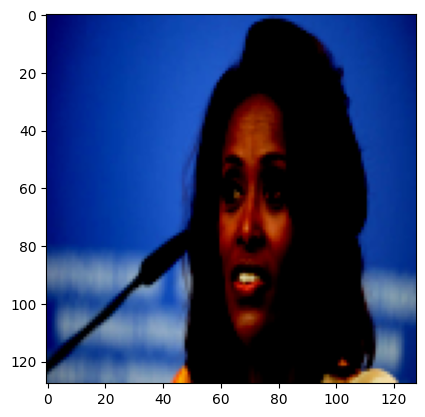

In [ ]:
# the dataloader is an iterable object ...
for images, labels in train_image_loader:
    print(images.shape, labels.shape)
    image = images[0].numpy()
    label = labels[0].item()

Loaded: 0%Progress bar: 84.42%

    print(image.shape)
    print(train_image_dataset.class_names[label])

    image = np.transpose(image, (1, 2, 0)) # change dimension properly 
    print(image.shape)
    print(label)

    plt.imshow(image, vmin=0, vmax=255)

    break # don't plot for all batches for now... 

# The custom data loader for unstructured dataset can properly load the image dataset

# Custom CNN Architecture

In [24]:
# Train a custom CNN Architecture with dataloader...
import torch.nn as nn
import torch.optim as optim 

In [ ]:
class CustomCNNModel(nn.Module):
    # always in a NN define
    # input dim as image input size (depends on the data loader as 128x128)
    # num_classes also define on the dataset (we have 3 classes)
    def __init__(self, input_dim, num_classes):
        super(CustomCNNModel, self).__init__() # Initialize base model 
        self.input_dim = input_dim
        self.num_classes = num_classes

        self.conv_layers = nn.Sequential(
            # Conv1
            # in conv2d you specify the filter channels number 
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), # RGB require 3 channels, so always match input 
            nn.BatchNorm2d(32), # apply batch normalization on all features 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # half of original input 

            # Conv2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64), # apply batch normalization on all features 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # half of original input  

            # Conv3
            # in conv2d you specify the filter channels number 
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(128), # apply batch normalization on all features 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # half of original input  

            # Conv4
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(256), # apply batch normalization on all features 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # half of original input  
            # doubling the output size at each step 

            # the output of these convolutional blocks is required to know the size of next layer 
        )

        self._to_linear = self._get_conv_output(self.input_dim)

        # create the fully connected layers as sequential network 
        self.fc_layers = nn.Sequential(
            # Use the extracted features in a fully connected layers MLP, to train model on the patterns of menaingful features 
            nn.Linear(self._to_linear, 512), # Fully connected 
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(512, 128), 
            nn.ReLU(),
            nn.Linear(128, self.num_classes), 
        )

    def _get_conv_output(self,input_dim=128):
        with torch.no_grad(): # feed forward the conv layers withou tgradient calculation
            # create a dummy image
            dummy_input = torch.zeros(1, 3, input_dim, input_dim) # batch size of 1, 3xwxh
            dummy_output = self.conv_layers(dummy_input)

            # we want the length of the flatten output 
            to_linear = dummy_output.view(1, -1).size(1) # reshape as row vector 
            # initialize to_linear as number of required neurons in the first FC layer 
            return to_linear


    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1) # reshape in forward propagate, flatten for the FC layers
        x = self.fc_layers(x)
        return x
    # after the forward the argmax is extracted to get the class

In [27]:
# Initialize model 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CustomCNNModel(input_dim=128, num_classes=3).to(device) # move model to device 

In [28]:
print(model)

CustomCNNModel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [29]:
# softmax will be applied automatically with the crossEntropy function 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
# Training loop 
epochs = 2

for epoch in range(epochs):
    model.train() # train mode so batch normalization and dropout has effect 
    running_loss = 0.0 
    # from 100 epochs, and 1000 images, with batch size 10
    # in single epoch I get 100 iterations.. I check the loss on a full batch_size, not on each iteration 
    # loss on batches

    for images, labels in train_image_loader:
        images, labels = images.to(device), labels.to(device) # send data to device
        # clear gradient before iteration 
        optimizer.zero_grad()

        outputs = model(images)
        #[x, 3, 128, 128] # you pass batches of images 

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}: Loss : {running_loss/len(train_image_loader)}")


Epoch 1/2: Loss : 107.32325801253319/95
Epoch 2/2: Loss : 60.1841658949852/95


In [35]:
# It is possible to save the model traioning parameters as: 
# contains all the weights and bias 
torch.save(model.state_dict(), "saved_models/cnn_model.pth")

In [37]:
# Evaluate model: 
model.eval()

# check accuracy as amount of correct prediction 
# accuracy = correct / total 
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_image_loader: 
        images, labels = images.to(device), labels.to(device) # send data to device

        outputs = model(images)

        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item() # sum over the batch size

print(f"Test accuracty is : {100*correct/total:.2f}%")


Test accuracty is : 72.50%


In [40]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 24.5 MB/s  0:00:02m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 24.8 MB/s  0:00:00 eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.4.0
    Uninstalling numpy-2.4.0:
      Successfully uninstalled numpy-2.4.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [opencv-python]0m [opencv-python]


In [41]:
import cv2

In [ ]:
# Define a class for inference ! 
# from input image  get the class 
class ImageClassifier: 
    # init with the pth of the model path
    # # the map class_names map allow to go from number label to class  
    def __init__(self, model_path, class_names):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = CustomCNNModel(input_dim=128, num_classes=3).to(self.device)

        # load_state_dict will load model paramters from model_path
        # the model architecture class should be deined before loading the wights, the model blueprint the architecture 
        self.model.load_state_dict(torch.load(model_path, map_location=self.device)) # load to GPU securely 

        #from load_state_dict now the model is properly initialized 
        self.model.eval() # eval mode
        self.class_names = self.class_names

        self.transform = transforms.Compose([
            transforms.Resize((128, 128)), # lower resolution for fatser speed 
            transforms.ToTensor(), # instead of pillow image, pytorch model expect tensors 
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalize in the range -1, 1
        ]) # model same tranformation o any image 

    def predict(self, image_path): # call predict method on image_path s input 
        # use PIL as expected by pytorch 
        image = Image.open(image_path).convert("RGB")
        # pass the image to transform 
        input_tensor = self.transform(image).unsqueeze(0).to(self.device) # unqueeze to add an exrtra dimension on 0 dimension, as expected by the model that want batch sizes 

        with torch.no_grad():
            output = self.model(input_tensor)

            _, predicted = torch.max(output, 1)
            # get labels explicitly: 
            label = self.class_names[predicted.item()]

            image = cv2.imread(image_path)
            cv2.putText(image, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
            cv2.imwrite("/output/output_image.jpg", image)

            return label 
        


        

In [ ]:
# labels could be saved in a json file ! 
# Otherwise the dictionary is taken from the file itself 
# store the dict into json 
classifier = ImageClassifier("./saved_models/cnn_model.pth", train_image_dataset.class_names)

label = classifier.predict("./Classification_dataset_v3/images/test/Dog/dog_1014.jpg")